In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use the first GPU


In [4]:
import tensorflow as tf
print("Is Built with CUDA:", tf.test.is_built_with_cuda())
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Is Built with CUDA: True
Num GPUs Available: 1


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\miniAI\dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda img: tf.image.resize(img, [224, 224])
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda img: tf.image.resize(img, [224, 224])
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda img: tf.image.resize(img, [224, 224])
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4200 images belonging to 7 classes.
Found 840 images belonging to 7 classes.
Found 420 images belonging to 7 classes.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [7]:
# Callbacks
checkpoint = ModelCheckpoint('best_resnet_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]
)


Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 1.9647 - accuracy: 0.2012
Epoch 1: val_accuracy improved from -inf to 0.23214, saving model to best_resnet_model.h5
132/132 [==============================] - 52s 324ms/step - loss: 1.9647 - accuracy: 0.2012 - val_loss: 1.8620 - val_accuracy: 0.2321
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 1.8207 - accuracy: 0.2536
Epoch 2: val_accuracy improved from 0.23214 to 0.27619, saving model to best_resnet_model.h5
132/132 [==============================] - 39s 292ms/step - loss: 1.8207 - accuracy: 0.2536 - val_loss: 1.7718 - val_accuracy: 0.2762
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 1.7788 - accuracy: 0.2729
Epoch 3: val_accuracy improved from 0.27619 to 0.29286, saving model to best_resnet_model.h5
132/132 [==============================] - 38s 290ms/step - loss: 1.7788 - accuracy: 0.2729 - val_loss: 1.7639 - val_accuracy: 0.2929
Epoch 4/50
132/132 [==============

14/14 [==============================] - 4s 223ms/step
Accuracy: 0.3880952380952381
mAP: 0.4023873422366142


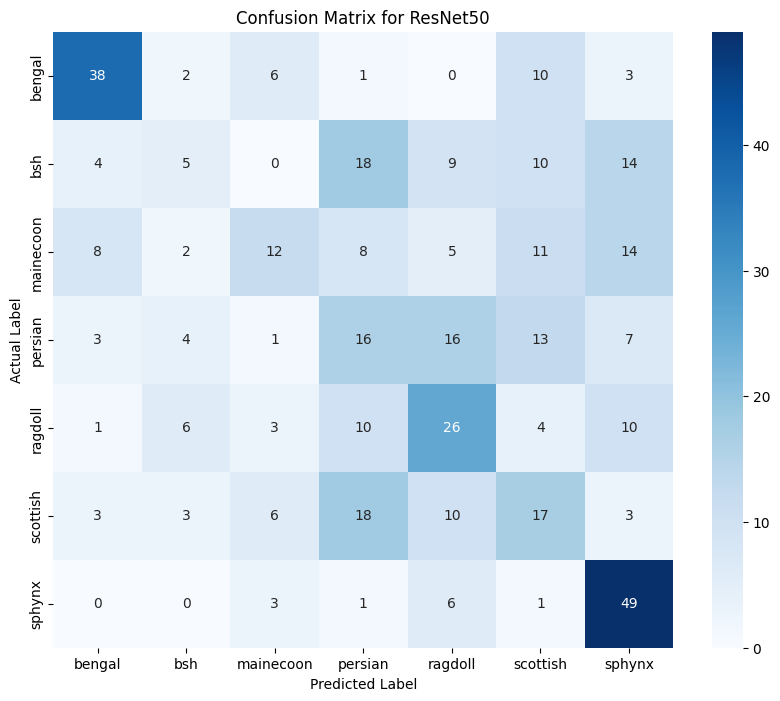

Classification Report for ResNet50
              precision    recall  f1-score   support

      bengal       0.67      0.63      0.65        60
         bsh       0.23      0.08      0.12        60
   mainecoon       0.39      0.20      0.26        60
     persian       0.22      0.27      0.24        60
     ragdoll       0.36      0.43      0.39        60
    scottish       0.26      0.28      0.27        60
      sphynx       0.49      0.82      0.61        60

    accuracy                           0.39       420
   macro avg       0.37      0.39      0.36       420
weighted avg       0.37      0.39      0.36       420



In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt

# Load the best model
model = tf.keras.models.load_model('best_resnet_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys(), zero_division=0))



Found 4200 images belonging to 7 classes.
Found 840 images belonging to 7 classes.
Found 420 images belonging to 7 classes.
Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 2.0127 - accuracy: 0.2052
Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to best_resnet50_model.h5
132/132 [==============================] - 29s 198ms/step - loss: 2.0127 - accuracy: 0.2052 - val_loss: 1.8847 - val_accuracy: 0.2083
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 1.8160 - accuracy: 0.2579
Epoch 2: val_accuracy improved from 0.20833 to 0.22976, saving model to best_resnet50_model.h5
132/132 [==============================] - 25s 192ms/step - loss: 1.8160 - accuracy: 0.2579 - val_loss: 1.8548 - val_accuracy: 0.2298
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 1.7890 - accuracy: 0.2638
Epoch 3: val_accuracy improved from 0.22976 to 0.29167, saving model to best_resnet50_model.h5
132/132 [=============================

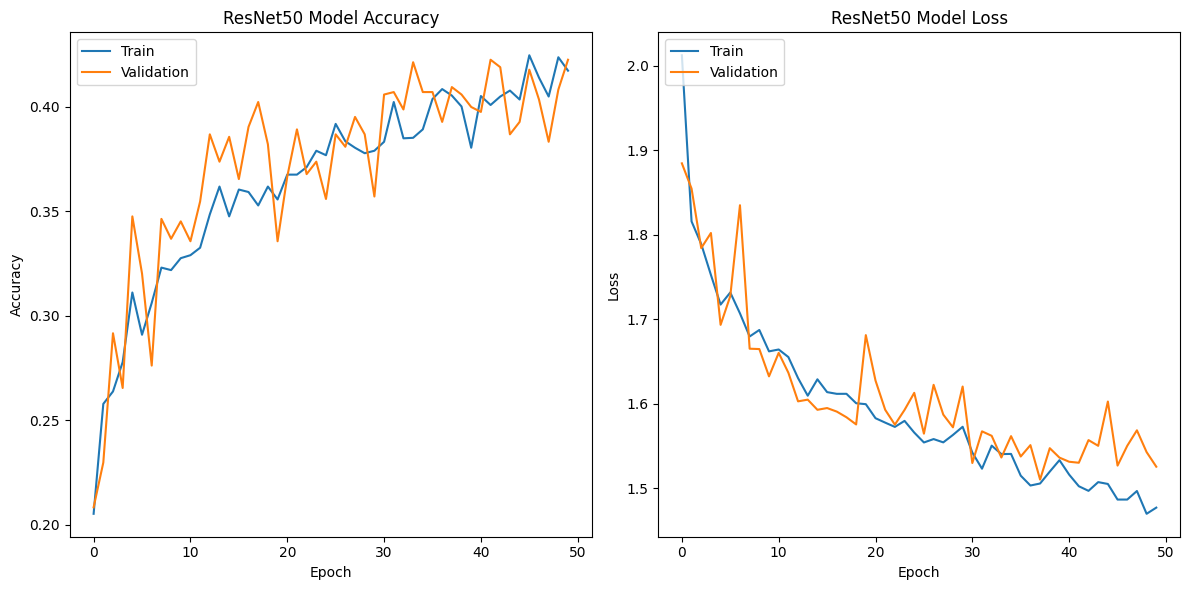

14/14 [==============================] - 3s 133ms/step
Accuracy: 0.38333333333333336
mAP: 0.4104310827920699


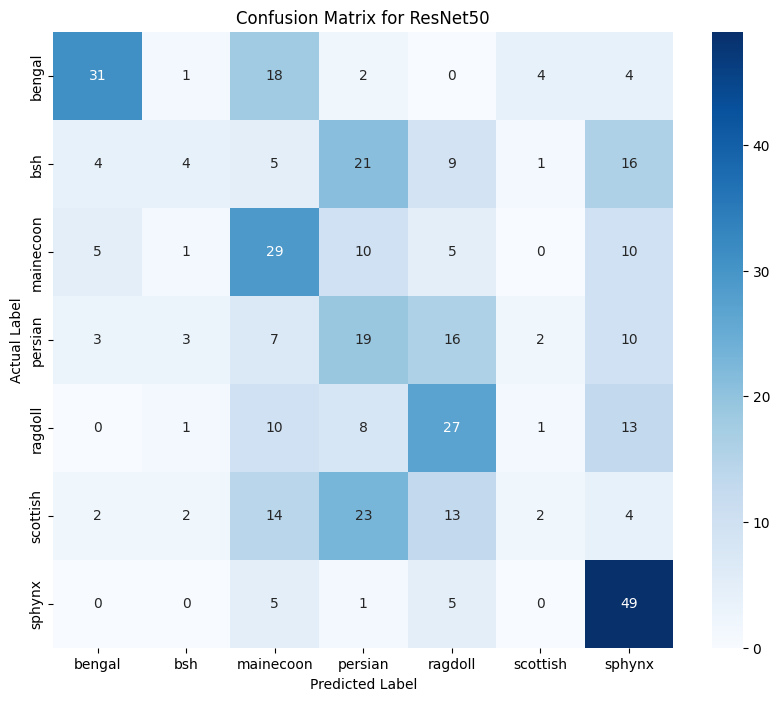

Classification Report for ResNet50
              precision    recall  f1-score   support

      bengal       0.69      0.52      0.59        60
         bsh       0.33      0.07      0.11        60
   mainecoon       0.33      0.48      0.39        60
     persian       0.23      0.32      0.26        60
     ragdoll       0.36      0.45      0.40        60
    scottish       0.20      0.03      0.06        60
      sphynx       0.46      0.82      0.59        60

    accuracy                           0.38       420
   macro avg       0.37      0.38      0.34       420
weighted avg       0.37      0.38      0.34       420



In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\miniAI\\dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators without additional preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys(),zero_division=0))


Found 4200 images belonging to 7 classes.
Found 840 images belonging to 7 classes.
Found 420 images belonging to 7 classes.
Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 1.0870 - accuracy: 0.6569
Epoch 1: val_accuracy improved from -inf to 0.75238, saving model to best_resnet50_model.h5
132/132 [==============================] - 47s 332ms/step - loss: 1.0870 - accuracy: 0.6569 - val_loss: 0.6895 - val_accuracy: 0.7524
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.7448
Epoch 2: val_accuracy improved from 0.75238 to 0.80833, saving model to best_resnet50_model.h5
132/132 [==============================] - 43s 321ms/step - loss: 0.7069 - accuracy: 0.7448 - val_loss: 0.5792 - val_accuracy: 0.8083
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.7810
Epoch 3: val_accuracy improved from 0.80833 to 0.81071, saving model to best_resnet50_model.h5
132/132 [=============================

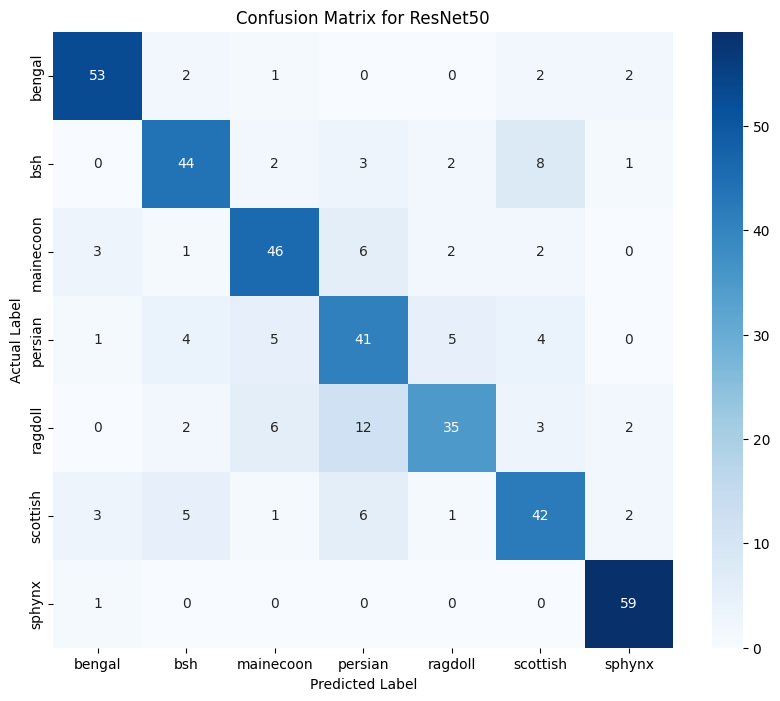

Classification Report for ResNet50
              precision    recall  f1-score   support

      bengal       0.87      0.88      0.88        60
         bsh       0.76      0.73      0.75        60
   mainecoon       0.75      0.77      0.76        60
     persian       0.60      0.68      0.64        60
     ragdoll       0.78      0.58      0.67        60
    scottish       0.69      0.70      0.69        60
      sphynx       0.89      0.98      0.94        60

    accuracy                           0.76       420
   macro avg       0.76      0.76      0.76       420
weighted avg       0.76      0.76      0.76       420



In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\miniAI\\dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


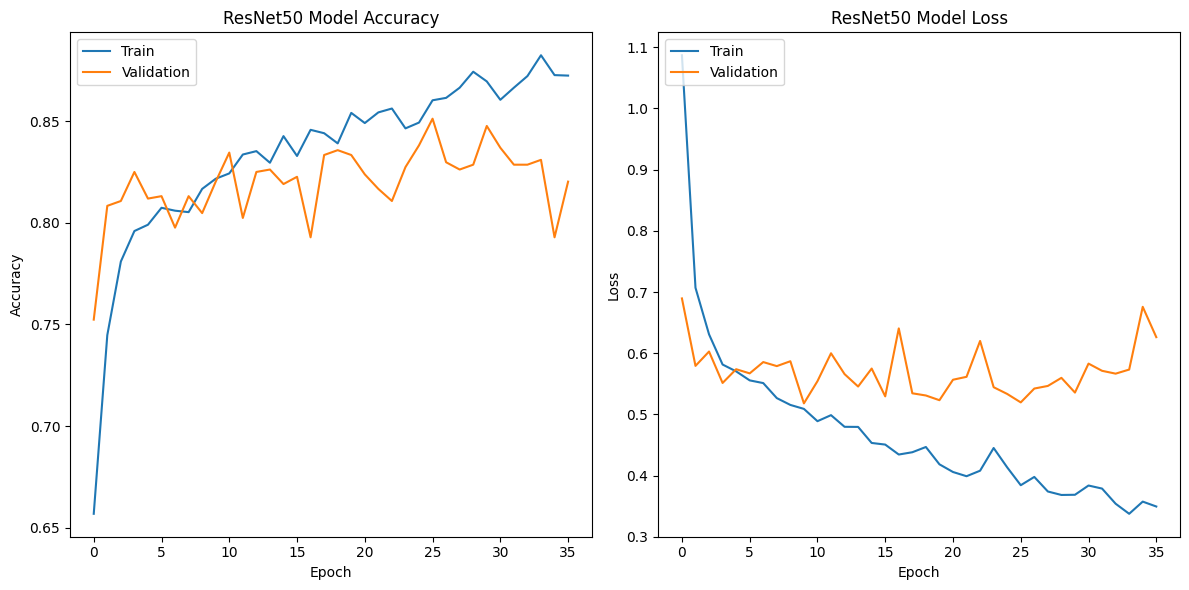

14/14 [==============================] - 3s 126ms/step
Accuracy: 0.7619047619047619
mAP: 0.8386765974977521


In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

Found 4200 images belonging to 7 classes.
Found 840 images belonging to 7 classes.
Found 420 images belonging to 7 classes.
Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 1.1880 - accuracy: 0.6376
Epoch 1: val_accuracy improved from -inf to 0.78333, saving model to best_resnet50_model.h5
132/132 [==============================] - 51s 364ms/step - loss: 1.1880 - accuracy: 0.6376 - val_loss: 0.6740 - val_accuracy: 0.7833
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.7390
Epoch 2: val_accuracy improved from 0.78333 to 0.82857, saving model to best_resnet50_model.h5
132/132 [==============================] - 44s 330ms/step - loss: 0.7152 - accuracy: 0.7390 - val_loss: 0.5655 - val_accuracy: 0.8286
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7707
Epoch 3: val_accuracy did not improve from 0.82857
132/132 [==============================] - 43s 326ms/step - loss: 0.6545 - accurac

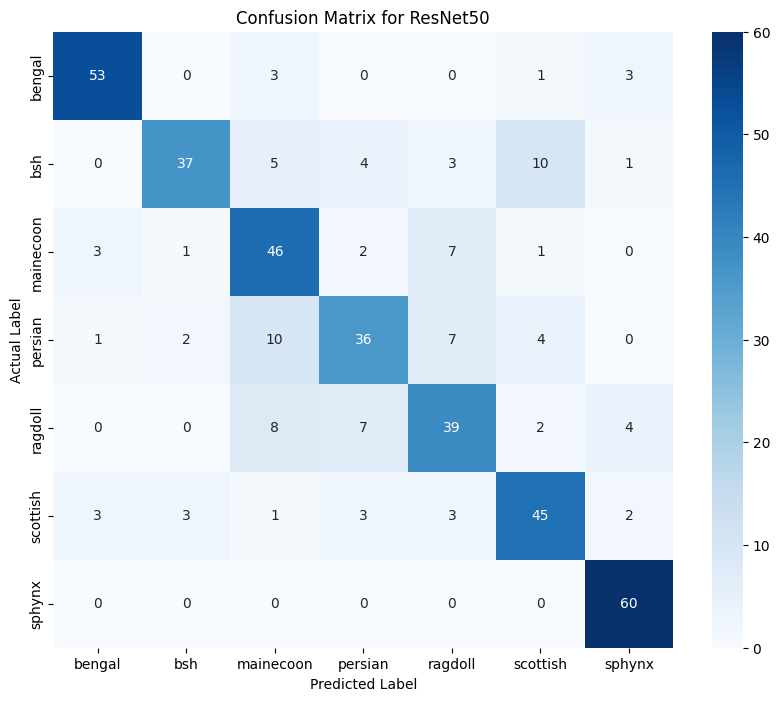

Classification Report for ResNet50
              precision    recall  f1-score   support

      bengal       0.88      0.88      0.88        60
         bsh       0.86      0.62      0.72        60
   mainecoon       0.63      0.77      0.69        60
     persian       0.69      0.60      0.64        60
     ragdoll       0.66      0.65      0.66        60
    scottish       0.71      0.75      0.73        60
      sphynx       0.86      1.00      0.92        60

    accuracy                           0.75       420
   macro avg       0.76      0.75      0.75       420
weighted avg       0.76      0.75      0.75       420



In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\miniAI\\dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time


# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


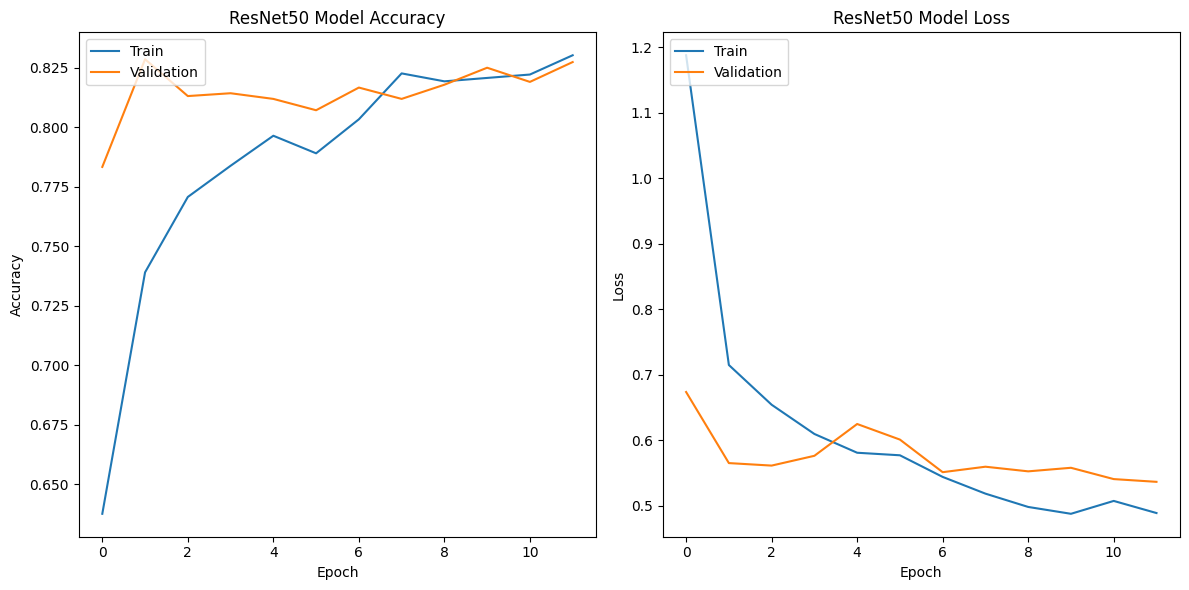

14/14 [==============================] - 2s 124ms/step
Accuracy: 0.7523809523809524
mAP: 0.8080594537372675


In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

In [8]:
import tensorflow as tf
print(tf.__version__)


2.10.1


In [9]:
import os

if os.path.exists('best_resnet_model.h5'):
    print("Model saved successfully.")
else:
    print("Model not saved.")


Model not saved.


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_resnet_model.h5', 
                             save_best_only=True, 
                             monitor='val_loss', 
                             mode='min', 
                             verbose=1)

# Make sure the callback is passed to the model fitting process
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint]
)


NameError: name 'model' is not defined

In [21]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Set the visible device to GPU 0 (RTX 3050)
    tf.config.set_visible_devices(gpus[0], 'GPU')
else:
    print("No GPU found.")


In [22]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus[0]}")
else:
    print("No GPU found. Using CPU.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
import tensorflow as tf

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Restrict TensorFlow to only use GPU 0
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Using GPU:", gpus[0].name)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Falling back to CPU.")


Physical devices cannot be modified after being initialized


In [2]:
import tensorflow as tf
import os

# Set visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0 (RTX 3050)

# Configure TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Avoid memory overflow issues
        print("Using GPU:", physical_devices[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
